In [14]:
pip install Pillow

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [5]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [6]:
pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/ec/6c/fab8113424af5049f85717e8e527ca3773299a3c6b02506e66436e19874f/opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB 2.0 MB/s eta 0:00:19
   ---------------------------------------- 0.4/38.8 MB 6.1 MB/s eta 0:00:07
   - -------------------------------------- 1.4/38.8 MB 14.6 MB/s eta 0:00:03
   ---- ----------------------------------- 3.9/38.8 MB 27.9 MB/s eta 0:00:02
   ------ --------------------------------- 6.2/38.8 MB 36.3 MB/s eta 0:00:01
   -------- ------------------------------- 8.1/38.8 MB 39.8 MB/s eta 0:00:01
   --------- ------------------------------ 9.0/38.8 MB 33.9 MB/s eta 0:00:01
   ---------- ----------------------------- 10.1/38.8 MB 32.5 MB/s eta 0:00:01
   ----------- ---------------------------- 11.4/38.8 MB 38.5 MB/s eta 0:00:01
   ---

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [1]:
# import packages
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image, ImageEnhance

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

from skimage import exposure  
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import models, layers

import warnings
warnings.filterwarnings("ignore")

print('modules loaded')



modules loaded


In [2]:
data_path = r"<directory to data folder>" 

blight = []
common_rust = []
gray_leaf_spot = []
healthy = []

for subfolder in os.listdir(data_path):
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        
        if subfolder == 'Blight':
            blight.append(image_path)
        elif subfolder == 'Common_Rust':
            common_rust.append(image_path)
        elif subfolder == 'Gray_Leaf_Spot':
            gray_leaf_spot.append(image_path)
        elif subfolder == 'Healthy':
            healthy.append(image_path)

# Create a dictionary to store all arrays
image_data = {
    'blight': blight,
    'common_rust': common_rust,
    'gray_leaf_spot': gray_leaf_spot,
    'healthy': healthy
}

# Create a DataFrame for overview
data = pd.DataFrame({
    'blight': pd.Series(blight),
    'common_rust': pd.Series(common_rust),
    'gray_leaf_spot': pd.Series(gray_leaf_spot),
    'healthy': pd.Series(healthy)
})


In [3]:
data.head()

blight  \
0  C:\Users\USER\OneDrive - Universiti Teknologi ...   
1  C:\Users\USER\OneDrive - Universiti Teknologi ...   
2  C:\Users\USER\OneDrive - Universiti Teknologi ...   
3  C:\Users\USER\OneDrive - Universiti Teknologi ...   
4  C:\Users\USER\OneDrive - Universiti Teknologi ...   

                                         common_rust  \
0  C:\Users\USER\OneDrive - Universiti Teknologi ...   
1  C:\Users\USER\OneDrive - Universiti Teknologi ...   
2  C:\Users\USER\OneDrive - Universiti Teknologi ...   
3  C:\Users\USER\OneDrive - Universiti Teknologi ...   
4  C:\Users\USER\OneDrive - Universiti Teknologi ...   

                                      gray_leaf_spot  \
0  C:\Users\USER\OneDrive - Universiti Teknologi ...   
1  C:\Users\USER\OneDrive - Universiti Teknologi ...   
2  C:\Users\USER\OneDrive - Universiti Teknologi ...   
3  C:\Users\USER\OneDrive - Universiti Teknologi ...   
4  C:\Users\USER\OneDrive - Universiti Teknologi ...   

                                             healthy  
0  C:\Users\USER\OneDrive - Universiti Teknologi ...  
1  C:\Users\USER\OneDrive - Universiti Teknologi ...  
2  C:\Users\USER\OneDrive - Universiti Teknologi ...  
3  C:\Users\USER\OneDrive - Universiti Teknologi ...  
4  C:\Users\USER\OneDrive - Universiti Teknologi ...

In [4]:
data.shape

(1306, 4)

In [5]:
# Path to save the processed images
processed_data_path = r"<directory to processed_image folder>"

# Create a mapping from label to folder name
label_to_folder = {
    'blight': 'blight',
    'common_rust': 'common_rust',
    'gray_leaf_spot': 'gray_leaf_spot',
    'healthy': 'healthy'
}


In [6]:
# Image enhancement 
def image_enhancement(ori_image):
    # Convert color 
    image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)
        
    # Color Correction
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)
    limg = cv2.merge((cl, a_channel, b_channel))
    corrected_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
        
    # Contrast enhancement
    pil_image = Image.fromarray(corrected_image)
    enhancer = ImageEnhance.Contrast(pil_image)
    enhanced_image = enhancer.enhance(1.5)  # Enhance contrast by a factor of 1.5
    
    # Convert back to numpy array (RGB)
    final_image = np.array(enhanced_image)

    # Pad the image to make it square
    final_image = pad_to_square(final_image)
        
    # Resize image to target size
    img_size = (256, 256)
    resized_image = cv2.resize(final_image, img_size)
    
    return resized_image
    

In [7]:
# Function to add padding to the image to make it square
def pad_to_square(image):
    height, width, _ = image.shape
    max_dim = max(height, width)
    top = (max_dim - height) // 2
    bottom = max_dim - height - top
    left = (max_dim - width) // 2
    right = max_dim - width - left
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_image

In [8]:
# Adaptive Histogram Equalization - Technique 1
def image_processing(image_path, label, index):
    # Load image
    ori_image = cv2.imread(image_path)
    
    # Perform image enhancement first
    resized_image = image_enhancement(ori_image)
    
    # Enhance contrast using CLAHE (Adaptive Histogram Equalization)
    image_enhanced = exposure.equalize_adapthist(resized_image)
    
    # Create folder path for saving processed images
    save_folder = os.path.join(processed_data_path, label_to_folder[label])
    os.makedirs(save_folder, exist_ok=True)
    
    # Create file name based on label and index
    file_name = f"Corn_{label.capitalize()}_{index + 1}.jpg"
    save_path = os.path.join(save_folder, file_name)
    
    # Save the processed image
    cv2.imwrite(save_path, (image_enhanced * 255).astype(int))
    
    return save_path

Processing index 0/1305...


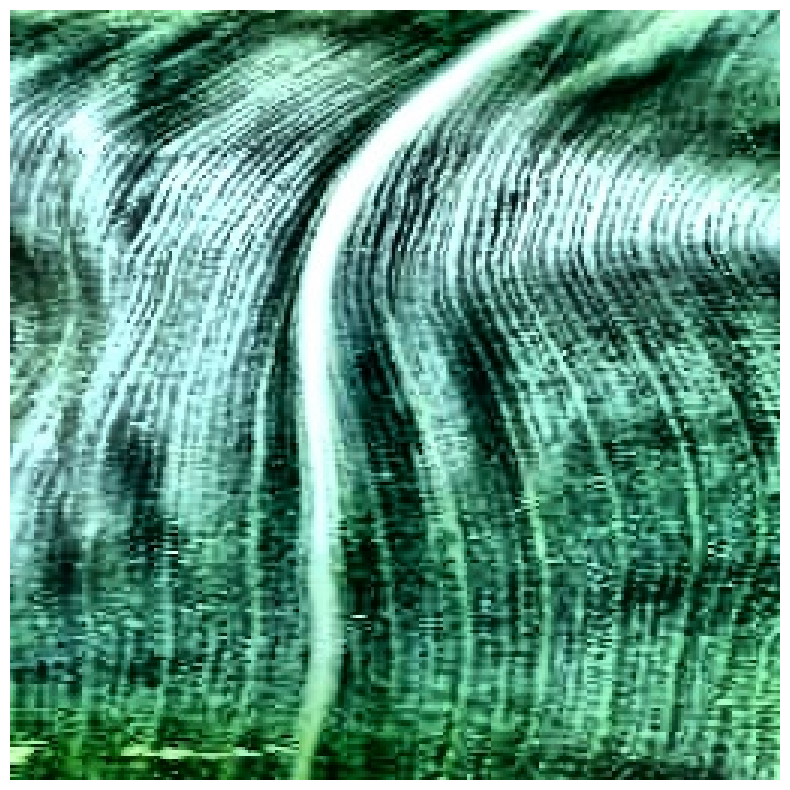

Processing index 1/1305...
Processing index 2/1305...
Processing index 3/1305...
Processing index 4/1305...
Processing index 5/1305...
Processing index 6/1305...
Processing index 7/1305...
Processing index 8/1305...
Processing index 9/1305...
Processing index 10/1305...
Processing index 11/1305...
Processing index 12/1305...
Processing index 13/1305...
Processing index 14/1305...
Processing index 15/1305...
Processing index 16/1305...
Processing index 17/1305...
Processing index 18/1305...
Processing index 19/1305...
Processing index 20/1305...
Processing index 21/1305...
Processing index 22/1305...
Processing index 23/1305...
Processing index 24/1305...
Processing index 25/1305...
Processing index 26/1305...
Processing index 27/1305...
Processing index 28/1305...
Processing index 29/1305...
Processing index 30/1305...
Processing index 31/1305...
Processing index 32/1305...
Processing index 33/1305...
Processing index 34/1305...
Processing index 35/1305...
Processing index 36/1305...
P

In [9]:
# Iterate through each image path, preprocess and save
for index, row in data.iterrows():
    print(f"Processing index {index}/{len(data) - 1}...")
    
    for label in label_to_folder:
        image_path = row[label]
        
        try:
            save_path = image_processing(image_path, label, index)
        except Exception as e:
            print(f"Image path for label '{label}': {image_path}")
            print(f"Error processing image: {e}")
            continue

    if index == 0:
        processed_image = cv2.imread(save_path)
        plt.figure(figsize=(10, 10))
        plt.imshow(processed_image)
        plt.axis("off")
        plt.show()

print("Image preprocessing and saving complete.")

In [10]:
# Base directory where processed images are saved
base_output_dir = r"<directory to processed_image folder>"

# Initialize lists to store image paths and labels
images = []
labels = []

# Iterate through each label folder in the base output directory
for label in os.listdir(base_output_dir):
    label_dir = os.path.join(base_output_dir, label)
    
    if os.path.isdir(label_dir):
        # Iterate through each image file in the label folder
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg'):
                # Construct the image path
                image_path = os.path.join(label_dir, filename)
                images.append(image_path)
                labels.append(label)

# Create a DataFrame from the collected image paths and labels
data = pd.DataFrame({'image': images, 'label': labels})

In [11]:
# Split the dataset into train (85%), validation (7.5%), and test (7.5%) sets
strat = data['label']
train_df, temp_df = train_test_split(data, train_size=0.85, shuffle=True, random_state=123, stratify=strat)
strat = temp_df['label']
valid_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

# Optionally, reset the index for each dataframe
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Display the sizes of each dataset (optional)
print(f"Number of samples in train set: {len(train_df)}")
print(f"Number of samples in validation set: {len(valid_df)}")
print(f"Number of samples in test set: {len(test_df)}")

Number of samples in train set: 3559
Number of samples in validation set: 314
Number of samples in test set: 315


In [12]:
# Define image generator parameters
batch_size = 32
img_size = (256, 256)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Initialize ImageDataGenerators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Create data generators
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True,
                                       batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True,
                                       batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False,
                                      batch_size=batch_size)

Found 3559 validated image filenames belonging to 4 classes.
Found 314 validated image filenames belonging to 4 classes.
Found 315 validated image filenames belonging to 4 classes.


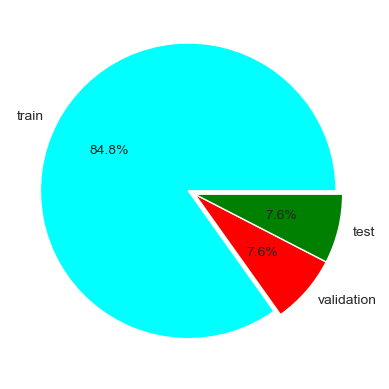

<Figure size 640x480 with 0 Axes>

In [13]:
# Plotting the pie chart
plt.pie([len(train_gen), len(valid_gen), len(test_gen)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['aqua', 'red', 'green'], explode=(0.05, 0, 0))
plt.show()
plt.savefig('dataset_pie.png')

In [14]:
print(train_gen.class_indices)
print(test_gen.class_indices)
print(valid_gen.class_indices)

{'blight': 0, 'common_rust': 1, 'gray_leaf_spot': 2, 'healthy': 3}
{'blight': 0, 'common_rust': 1, 'gray_leaf_spot': 2, 'healthy': 3}
{'blight': 0, 'common_rust': 1, 'gray_leaf_spot': 2, 'healthy': 3}


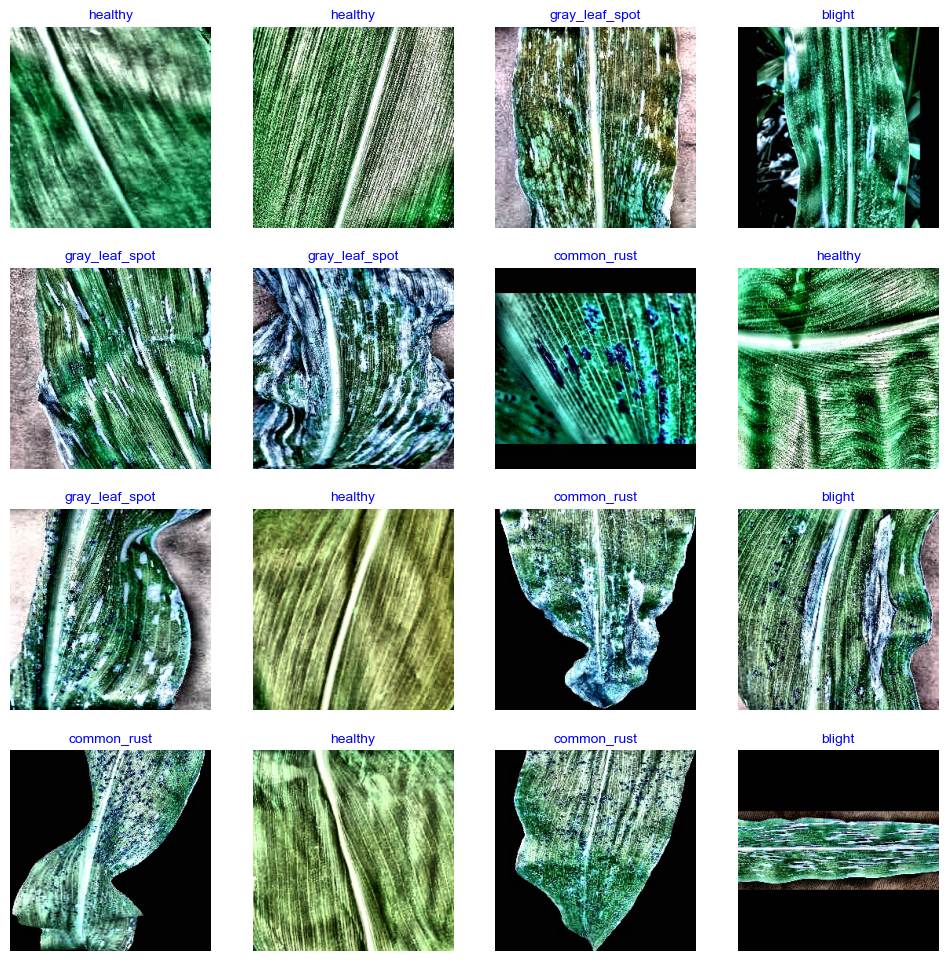

In [15]:
# Display some of the images
g_dict = train_gen.class_indices      
classes = list(g_dict.keys())       
images, labels = next(train_gen)      

plt.figure(figsize= (12, 12))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')
plt.show()

In [16]:
# Define the model architecture
n_classes = 4
input_shape = (256, 256, 3)  

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name='Conv1'),
    layers.MaxPooling2D((2, 2), name='MaxPool1'),
    layers.Conv2D(64, (3, 3), activation='relu', name='Conv2'),
    layers.MaxPooling2D((2, 2), name='MaxPool2'),
    layers.Conv2D(64, (3, 3), activation='relu', name='Conv3'),
    layers.MaxPooling2D((2, 2), name='MaxPool3'),
    layers.Conv2D(64, (3, 3), activation='relu', name='Conv4'),
    layers.MaxPooling2D((2, 2), name='MaxPool4'),
    layers.Flatten(name='Flatten'),
    layers.Dense(64, activation='relu', name='Dense1'),
    layers.Dense(n_classes, activation='softmax', name='Output')
])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 254, 254, 32)      896       
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 127, 127, 32)      0         
                                                                 
 Conv2 (Conv2D)              (None, 125, 125, 64)      18496     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 62, 62, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 60, 60, 64)        36928     
                                                                 
 MaxPool3 (MaxPooling2D)     (None, 30, 30, 64)        0         
                                                                 
 Conv4 (Conv2D)              (None, 28, 28, 64)       

In [17]:
# Define a callback to stop training once validation accuracy reaches 98%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("\nReached 98% validation accuracy. Stopping training!")
            self.model.stop_training = True

callbacks = myCallback()

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_gen,
    epochs=4,
    batch_size=32,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[callbacks]
)

Epoch 1/4


112/112 [==============================] - 119s 1s/step - loss: 5.9511 - accuracy: 0.6075 - val_loss: 0.5277 - val_accuracy: 0.7516
Epoch 2/4
112/112 [==============================] - 110s 979ms/step - loss: 0.4914 - accuracy: 0.7786 - val_loss: 0.4147 - val_accuracy: 0.8248
Epoch 3/4
112/112 [==============================] - 109s 975ms/step - loss: 0.3483 - accuracy: 0.8516 - val_loss: 0.3381 - val_accuracy: 0.8408
Epoch 4/4
112/112 [==============================] - 106s 949ms/step - loss: 0.2644 - accuracy: 0.8899 - val_loss: 0.3489 - val_accuracy: 0.8344


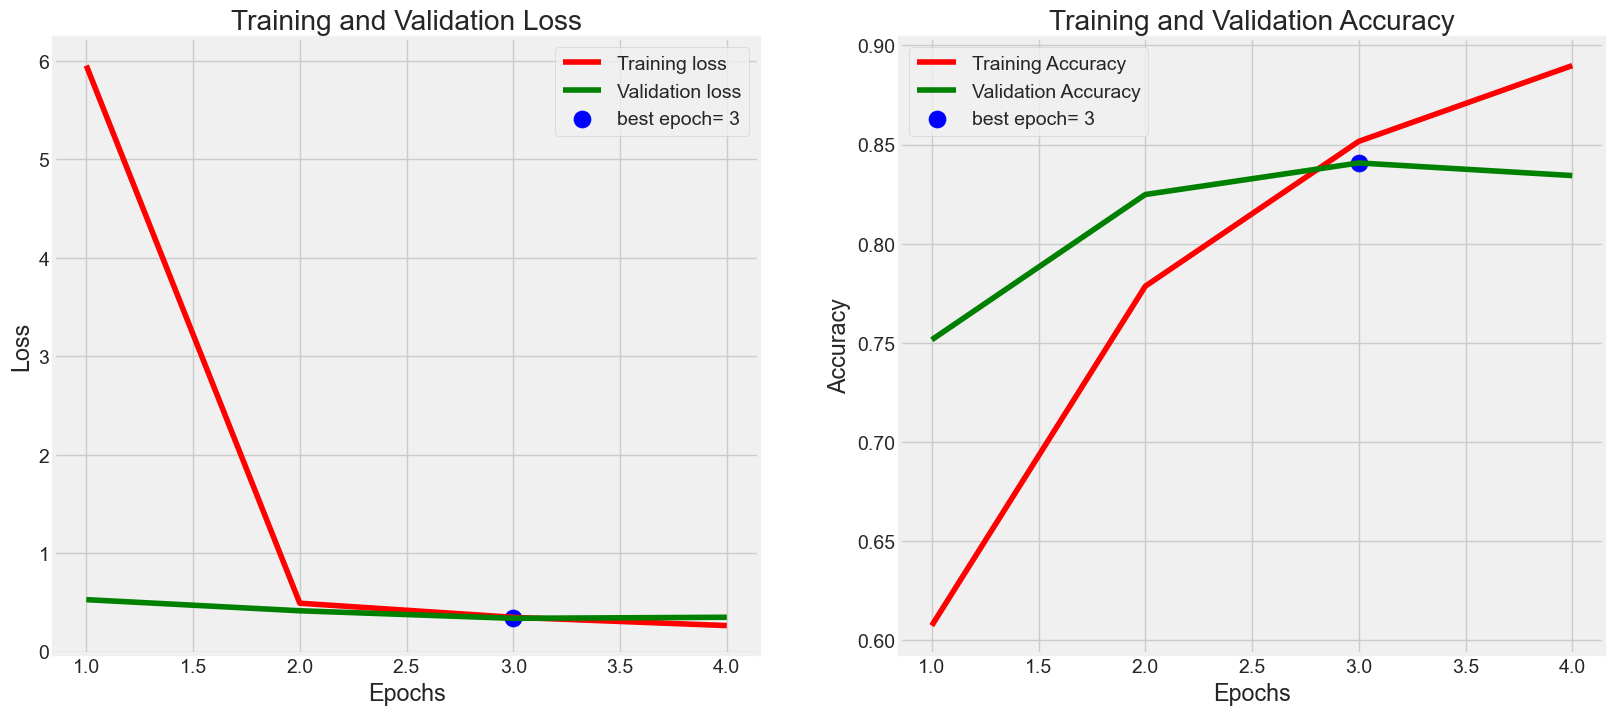

In [18]:
# Retrieve history data
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Identify best epoch based on validation loss and accuracy
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plotting training and validation loss
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [19]:
# Evaluate on validation data
loss, accuracy = model.evaluate(valid_gen)
print("Validation Accuracy:", accuracy)

10/10 [==============================] - 3s 269ms/step - loss: 0.3489 - accuracy: 0.8344
Validation Accuracy: 0.8343949317932129


In [20]:
# Evaluate on train, validation, and test datasets
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 [==============================] - 1s 280ms/step - loss: 0.2609 - accuracy: 0.9125
Train Loss:  0.14697137475013733
Train Accuracy:  0.956250011920929
--------------------
Valid Loss:  0.36098113656044006
Valid Accuracy:  0.8187500238418579
--------------------
Test Loss:  0.26091524958610535
Test Accuracy:  0.9125000238418579


In [21]:
# Predictions on test data
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

10/10 [==============================] - 3s 273ms/step


In [22]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                precision    recall  f1-score   support

        blight       0.83      0.80      0.82        86
   common_rust       0.95      1.00      0.98        98
gray_leaf_spot       0.73      0.74      0.74        43
       healthy       1.00      0.97      0.98        88

      accuracy                           0.90       315
     macro avg       0.88      0.88      0.88       315
  weighted avg       0.90      0.90      0.90       315



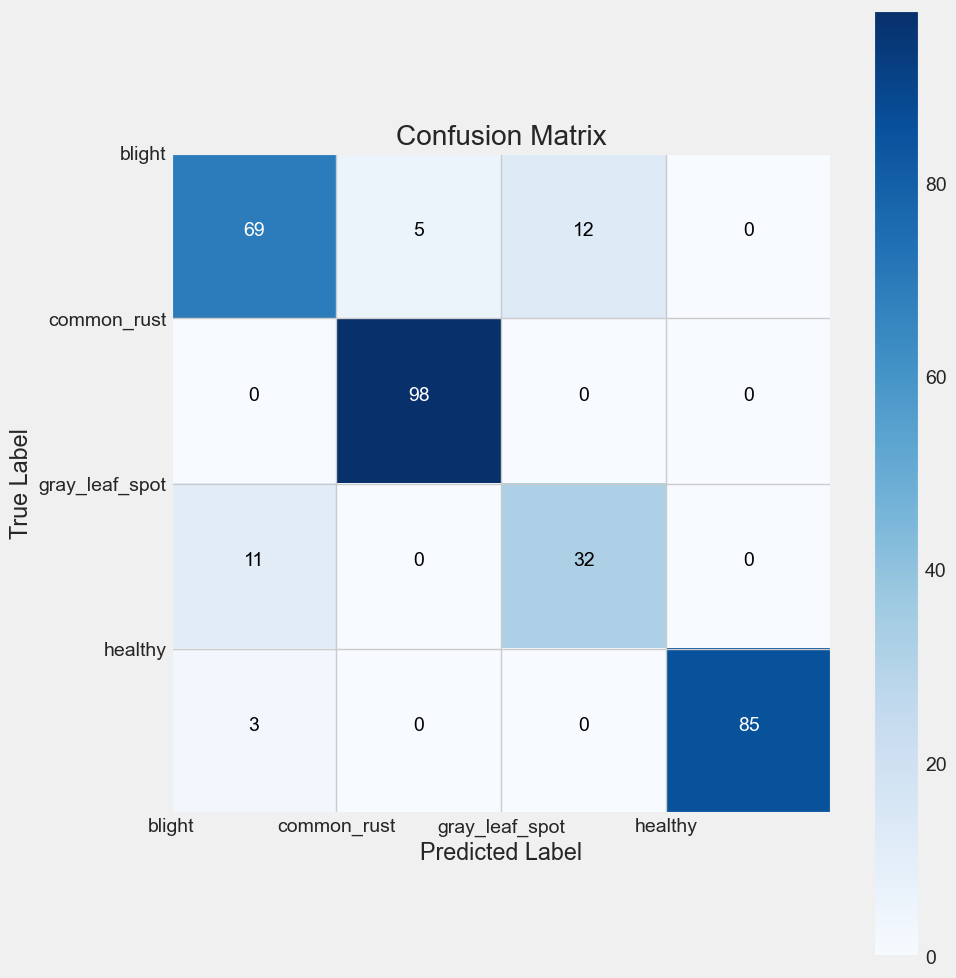

In [23]:
# Confusion Matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)  
plt.yticks(tick_marks - 0.5, classes) 


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Model Save

In [24]:
model.save('modelAdaptiveHistogramEqualization.h5')

1/1 [==============================] - 0s 129ms/step


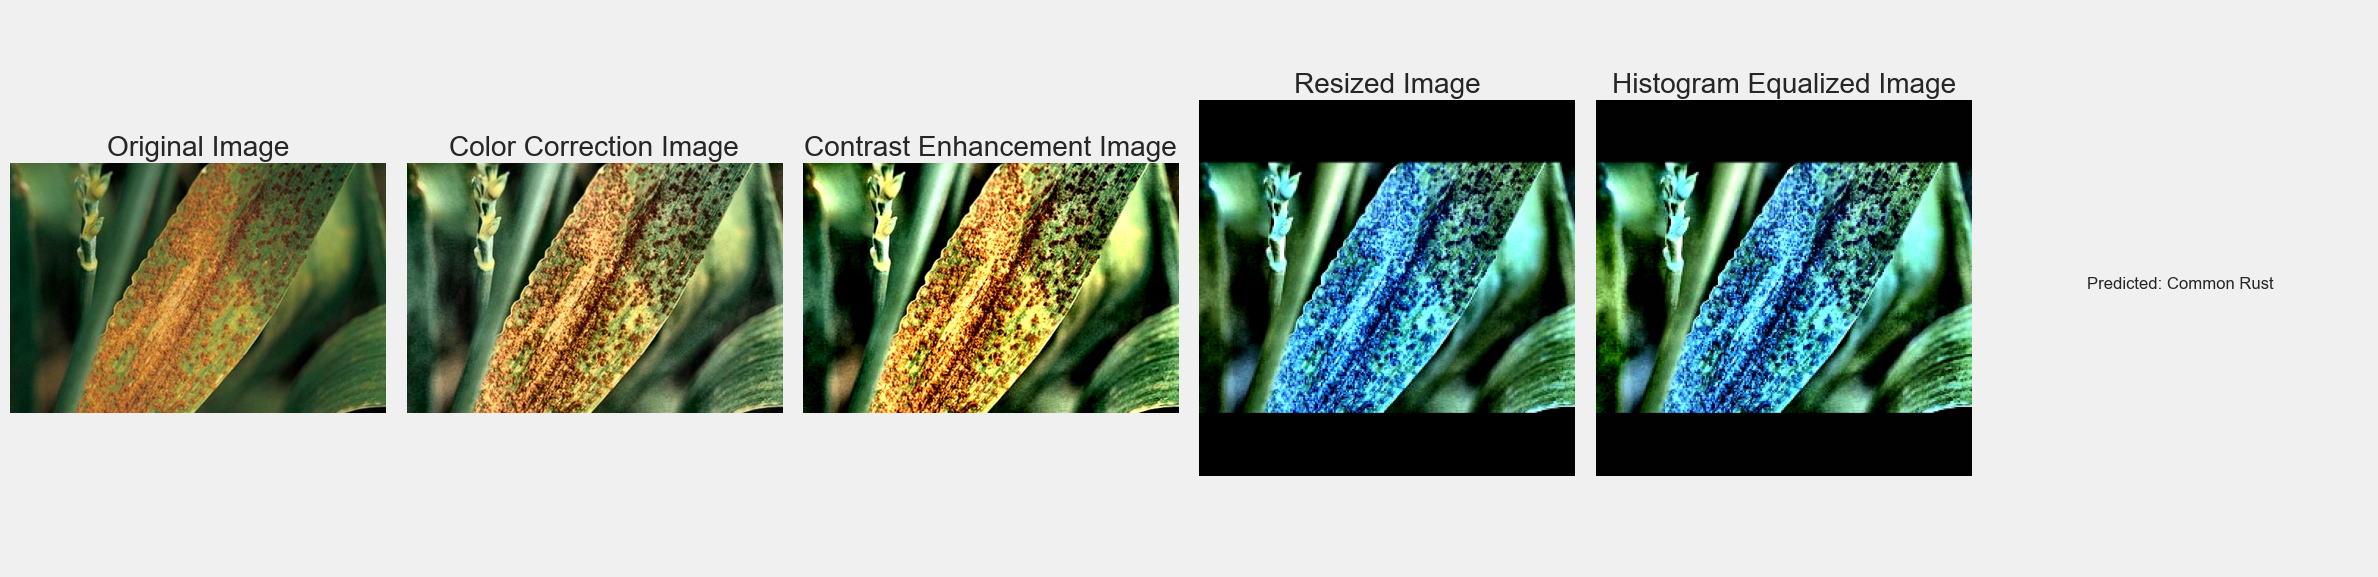

In [44]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from skimage import exposure  # Importing exposure for adaptive histogram equalization

# Load your trained model
model_path = 'modelAdaptiveHistogramEqualization.h5'
model = load_model(model_path)

# Function to perform color correction
def upload_image_enhancement(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert color if necessary
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Color Correction
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l_channel)
    limg = cv2.merge((cl, a_channel, b_channel))
    corrected_image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    
    # Contrast enhancement
    pil_image = Image.fromarray(corrected_image)
    enhancer = ImageEnhance.Contrast(pil_image)
    enhanced_image = enhancer.enhance(1.5)  # Enhance contrast by a factor of 1.5
    
    # Convert back to numpy array (RGB)
    final_image = np.array(enhanced_image)

    # Pad the image to make it square
    final_image = pad_to_square(final_image)
    
    # Resize image to target size
    img_size = (256, 256)
    resized_image = cv2.resize(final_image, img_size)
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR)
    
    return image, corrected_image, enhanced_image, resized_image

# Function to add padding to the image to make it square
def pad_to_square(image):
    height, width, _ = image.shape
    max_dim = max(height, width)
    top = (max_dim - height) // 2
    bottom = max_dim - height - top
    left = (max_dim - width) // 2
    right = max_dim - width - left
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_image

def adaptive_histogram_equalization(enhanced_image):
    # Enhance contrast using CLAHE (Adaptive Histogram Equalization)
    image = exposure.equalize_adapthist(enhanced_image)
    
    return image

# Function to predict using the loaded model
def predict_image(image_path, model):
    # Enhanced image
    original_image, corrected_image, enhanced_image, resized_image = upload_image_enhancement(image_path)

    # Display all images
    fig, axs = plt.subplots(1, 6, figsize=(24, 6))  # Increased to accommodate space for predicted label

    titles = ["Original Image", "Color Correction Image", "Contrast Enhancement Image", "Resized Image", "Histogram Equalized Image"]

    axs[0].imshow(original_image)
    axs[0].set_title(titles[0])
    axs[0].axis("off")

    axs[1].imshow(corrected_image)
    axs[1].set_title(titles[1])
    axs[1].axis("off")

    axs[2].imshow(enhanced_image)
    axs[2].set_title(titles[2])
    axs[2].axis("off")

    axs[3].imshow(resized_image)
    axs[3].set_title(titles[3])
    axs[3].axis("off")

    # Adaptive histogram equalization image
    final_image = adaptive_histogram_equalization(resized_image)
    axs[4].imshow(final_image)
    axs[4].set_title(titles[4])
    axs[4].axis("off")

    # Predict and display label
    prediction = model.predict(np.expand_dims(final_image, axis=0))
    predicted_class = np.argmax(prediction, axis=-1)
    class_labels = {0: 'Blight', 1: 'Common Rust', 2: 'Gray Leaf Spot', 3: 'Healthy'}  # Update with your class labels
    predicted_label = class_labels[predicted_class[0]]

    axs[5].text(0.5, 0.5, f"Predicted: {predicted_label}", fontsize=12, ha='center')
    axs[5].axis("off")

    plt.tight_layout()
    plt.show()
    
    return predicted_class

# Example usage:
image_path = r"<directory to specific image>"

predicted_class = predict_image(image_path, model)
